In [1]:
import torch
import torchvision
import torchvision.transforms as T
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision.io import read_image
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler

load_path = 'checkpoint/model_final_HGD'

from models.cnnmodel import Net
from models.hgd_model2 import Generator
from HandGestureDataset import HandGestureDataSet as HGD
from utils import HGDThreshold as HGDT
from utils import noise_sample
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

from pathlib import Path

In [2]:
# path = "C:/Users/Krishanu/Desktop/Education/Programcodes/Python/DeepLearning/Project/leapGestRecog/"
path = str(Path.home())+'/Documents/data/leapGestRecog/'

training = HGD(root = path, train = True,
    transform = T.Compose([
                T.ToPILImage(),
              
                # T.RandomHorizontalFlip(p=0.5),
                T.Resize((240,240)),
                # T.CenterCrop((190,180)),
                # T.RandomCrop((180,180)),
                T.Resize((64,64)),
                T.RandomRotation(20),
                T.ToTensor(), 
                HGDT(55.0/256.0),
                # T.Normalize(100/256.0,1),
                # T.RandomAdjustSharpness(sharpness_factor = 4,p=0.5),
                # T.RandomAutocontrast(p=1),

                ])
            )
validation = HGD(root = path, train= False,
    transform = T.Compose([
                T.ToPILImage(),
              
                # T.RandomHorizontalFlip(p=0.5),
                T.Resize((240,240)),
                # T.CenterCrop((190,180)),
                # T.RandomCrop((180,180)),
                T.Resize((64,64)),
                T.RandomRotation(20),
                T.ToTensor(), 
                HGDT(55.0/256.0),
                # T.Normalize(100/256.0,1),
                # T.RandomAdjustSharpness(sharpness_factor = 4,p=0.5),
                # T.RandomAutocontrast(p=1),

                ])
            )

batch_size = 32
train_batch = DataLoader(training, batch_size=batch_size, shuffle=True, num_workers= 8)
val_batch = DataLoader(validation, batch_size=batch_size, shuffle=True, num_workers= 8)

In [3]:
def train_model(model, training_data, device, optimizer, epoch, netG, use_gen=True, gen_iter = 1, use_train = True):

    """
    This is the main function for training a deep neural network.
    Inputs:
    {
    model: The Neural network
    training_data: Training data with labels
    device: Physical location of where data is stored ("CPU" or "GPU")
    optimizer: Optimizer Function e.g. torch.optim.adam
    scheduler: The type of scheduling for modifying the learning rate
    num_epochs: number of iterations to train on the data
    }

    """
    total_loss = 0
    correct = 0
    model.train() #Set the model to "training" mode and compute gradients
    if use_train:
        print('-'*25)
        print('Training using Training Data')
        print('-'*25)
        for batch_idx, (image, label) in enumerate(training_data):
            image, label = image.to(device), label.to(device) # place the input data into gpu ram or cpu ram
            optimizer.zero_grad()
            output = model(image)
            loss = nn.functional.cross_entropy(output, label)
            loss.backward()
            optimizer.step()
            with torch.no_grad():
                total_loss += loss.sum().item()
                pred = output.argmax(dim =1 , keepdim=True)
                correct += pred.eq(label.view_as(pred)).sum().item()
            if batch_idx % 100 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(image), len(training_data.dataset),
                    100. * batch_idx / len(training_data), loss.item()))

    total_loss_gen = 0
    correct_gen =0
    if use_gen:
        print('-'*25)
        print('Training using Generator Data')
        print('-'*25)
        for i in range(gen_iter):
            noise,idx,_,con = noise_sample(1,10,4,256,batch_size,device)
            target = torch.LongTensor(idx).to(device)
            image = netG(noise.squeeze((2,3)),target.view(-1,1),con)
            label = torch.LongTensor(idx).to(device).squeeze(0)
            optimizer.zero_grad()
            output = model(image)
            loss = nn.functional.cross_entropy(output, label)
            loss.backward()
            optimizer.step()
            with torch.no_grad():
                total_loss_gen += loss.sum().item()
                pred = output.argmax(dim =1 , keepdim=True)
                correct_gen += pred.eq(label.view_as(pred)).sum().item()
            if i % 100 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, i * len(image), len(training_data.dataset),
                    100. * i / len(training_data), loss.item()))
    if use_gen and use_train:
        print('\nTotal Training Set: \n\tAverage loss: {:.4f}\n\tAccuracy: {}/{} ({}%)'.format(
            (total_loss+total_loss_gen)/(len(training_data.dataset)+batch_size*gen_iter),
            correct+correct_gen,
            len(training_data.dataset)+batch_size*gen_iter,
            100*(correct+correct_gen)/(batch_size*gen_iter+len(training_data.dataset))))
    if use_train:
        print('\nTraining Set: \n\tAverage loss: {:.4f}\n\tAccuracy: {}/{} ({}%)'.format(
        (total_loss)/len(training_data.dataset),
        correct,
        len(training_data.dataset),
        100*(correct)/len(training_data.dataset)))
    if use_gen:
        print('\nGenerator Set: \n\tAverage loss: {:.4f}\n\tAccuracy: {}/{} ({}%)'.format(
            (total_loss_gen)/(batch_size*gen_iter),
            correct_gen,
            batch_size*gen_iter,
            100*correct_gen/(batch_size*gen_iter)))
    
    # wandb.watch(model)
    # wandb.log({'Training Loss':total_loss/len(training_data.dataset),'Training Accuracy':correct/len(training_data.dataset)},commit = False)



def validate_model(model, test_data,scheduler, device):

    """
    This is the function to monitor a deep neural network's performance on validation data. Sends images and predictions to wandb
    
    Inputs:
    {
    model: The Neural network
    test_data: test data with labels
    device: Physical location of where data is stored (CPU or GPU)
    }
    
    """
    
    model.eval() #Set the model to "evaluation" mode and NOT compute gradients
    total_loss = 0
    correct = 0 
    with torch.no_grad(): #Prevent pytorch from computing gradients
        for image, label in test_data:
            image, label = image.to(device), label.to(device) # place the input data into gpu ram or cpu ram
            output = model(image)
            total_loss = nn.functional.cross_entropy(output, label, reduction = 'sum').item()
            pred = output.argmax(dim =1 , keepdim=True)
            correct += pred.eq(label.view_as(pred)).sum().item()
    total_loss /= len(test_data.dataset)
    scheduler.step(total_loss)
    print('Test set: \n\tAverage loss: {:.4f}\n\tAccuracy: {}/{} ({}%)\n'.format(
            total_loss,
            correct, 
            len(test_data.dataset),
            100. * correct /len(test_data.dataset)))
    
    
    # wandb.log({'Validation Loss':total_loss,'Validation Accuracy':correct/len(test_data.dataset)},commit = False)
            
            
    #######################################################################################################
    # wandb_iter = iter(test_data)
    # wandb_i,wandb_l = wandb_iter.next()
    # with torch.no_grad():
    #     wandb.log({'Predictions':[wandb.Image(wandb_i[i],caption = f"Label: {int(wandb_l[i])}, Prediction: {int(torch.argmax(model(wandb_i[i].unsqueeze(0).to(device))))}") for i in range(10)] },commit = True)
    #######################################################################################################

# %%

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu" # Determines if the model will be trained on gpu or cpu
#------Initialize Generator------
netG = Generator().to(device)
state_dict = torch.load(load_path)
params = state_dict['params']
netG.load_state_dict(state_dict['netG'])
use_gen = True
gen_iter = 100

#-----Initialize CNN model-----
learning_rate = 6e-4
num_epochs = 10 # Number of times to look over the data.
model_ft = Net() # Initialize the model
model_ft = model_ft.to(device) # Send the model to Ram or GPU Ram
optimizer_ft = optim.Adam(model_ft.parameters(), lr=learning_rate, weight_decay = 7e-5) # Initialize optimizer
exp_lr_scheduler = lr_sched = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_ft,patience=3,threshold=0.01) #initialize scheduler. Every (1) epoch, reduce the learning rate by a factor of 0.7
use_train = True

print(len(train_batch.dataset))
print("Learning Rate: ",learning_rate,"\nBatch Size: ", batch_size)
print(device)

16000
Learning Rate:  0.0006 
Batch Size:  32
cuda


In [5]:
#################### WANDB Setup ###################
# wandb.init(project = 'ECE6254'
#         ,config = {'learning_rate':0.01, 'batch_size':64}
#             )
# config = wandb.config

# batch_size_train = config.batch_size
# batch_size_test = 1000
# learning_rate = config.learning_rate
####################################################

##### Main Loop for Training ######
for epoch in range(num_epochs):
            train_model(model_ft,
                        train_batch,
                        device, 
                        optimizer_ft, 
                        epoch,netG, 
                        use_gen,
                        gen_iter,
                        use_train)
            validate_model(model_ft,
                        val_batch,
                        exp_lr_scheduler,
                        device) 
###################################                         

#################################################
# wandb.finish()
#################################################


-------------------------
Training using Training Data
-------------------------
Train Epoch: 0 [0/16000 (0%)]	Loss: 2.302969
Train Epoch: 0 [3200/16000 (20%)]	Loss: 0.994203
Train Epoch: 0 [6400/16000 (40%)]	Loss: 0.420626
Train Epoch: 0 [9600/16000 (60%)]	Loss: 0.120736
Train Epoch: 0 [12800/16000 (80%)]	Loss: 0.121487
-------------------------
Training using Generator Data
-------------------------
Train Epoch: 0 [0/16000 (0%)]	Loss: 8.026547

Total Training Set: 
	Average loss: 0.0259
	Accuracy: 13770/19200 (71.71875%)

Training Set: 
	Average loss: 0.0180
	Accuracy: 12737/16000 (79.60625%)

Generator Set: 
	Average loss: 653.7396
	Accuracy: 1033/3200 (322812.5%)
Test set: 
	Average loss: 0.0116
	Accuracy: 1956/4000 (48.9%)

-------------------------
Training using Training Data
-------------------------
Train Epoch: 1 [0/16000 (0%)]	Loss: 1.041831
Train Epoch: 1 [3200/16000 (20%)]	Loss: 0.067155
Train Epoch: 1 [6400/16000 (40%)]	Loss: 0.036302
Train Epoch: 1 [9600/16000 (60%)]	Los

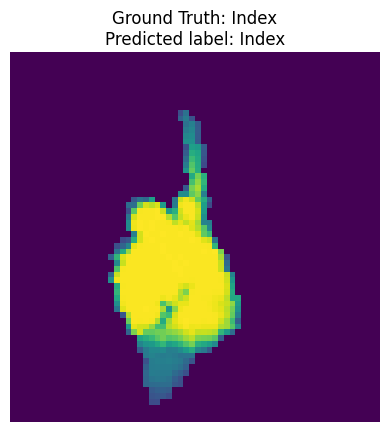

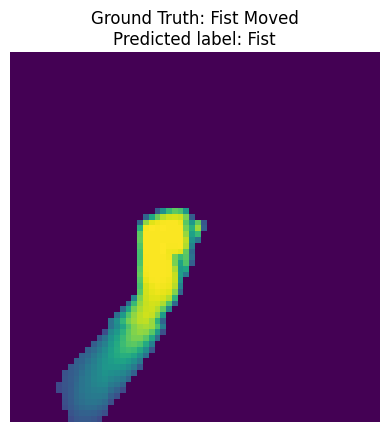

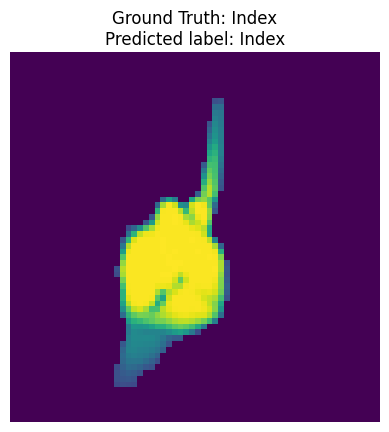

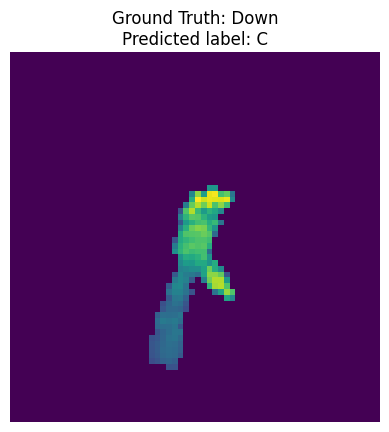

In [ ]:
import matplotlib.pyplot as plt
for i in range(0,4):
    val = iter(val_batch)
    img_val,gt = next(val)
    input_val = img_val.to(device = device)
    img_val = img_val.squeeze()
    model_ft.eval()
    output = model_ft(input_val)
    # ae_output = output.squeeze().cpu().detach().numpy()
    # print(output)
    # k = model_ft.forward_encoder(input)
    # print(k.shape)

    # print(output)
    Labels = {0:'Palm',
              1:'L',
              2:'Fist',
              3:'Fist Moved',
              4:'Thumb',
              5:'Index',
              6:'OK',
              7:'Palm Moved',
              8:'C',
              9:'Down',
              }
    plt.imshow(img_val[0])
    plt.title('Ground Truth: '+Labels[int(gt[0].detach().cpu().numpy())]+'\nPredicted label: '+Labels[int(torch.argmax(output[0]).item())])
    plt.axis('off')
    plt.show()

